In [1]:
import scvelo as scv
import pandas as pd 
import numpy as np
from anndata import AnnData
import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.patches as mpatches
import pickle
import os
import mnnpy
import leidenalg
from sknetwork.clustering import Louvain, BiLouvain, modularity, bimodularity
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from scipy import sparse
from IPython.display import SVG
import community
import gseapy as gp
import autograd
from autograd import grad, jacobian
from sklearn.linear_model import LinearRegression
from scipy import stats,signal
from community import community_louvain
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from filter_dispersion import filter_dispersion
from scipy.sparse import issparse
from scvelo.preprocessing.utils import get_mean_var,materialize_as_ndarray

In [2]:
data_path='C:/Users/zoro/Desktop/Frustration_paper/data_analysis/data/'
main_path='C:/Users/zoro/Desktop/Frustration_paper/data_analysis/'
result_path='result/'

In [3]:
adata=scv.read(result_path+'EG_dyn.h5ad')
adata.uns['velocity_graph']=adata.obsp['fp_transition_matrix']
t_list=['Ngn3 low EP','Ngn3 high EP','Fev+','Alpha']

In [4]:
T=adata.obsp['fp_transition_matrix']

# t = T[0]
# print(t)
# indices, p = t.indices, t.data
# print(indices,p)

In [5]:
adata

AnnData object with n_obs × n_vars = 1731 × 470
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'ntr'
    var: 'highly_variable_genes', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'PCs', 'clusters_colors', 'clusters_fine_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'grid_velocity_pca', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'pca_mean', 'pp', 'velocity_graph'
    obsm: 'X', 'X_pc

In [6]:
source_mean=np.mean(adata[(adata.obs['clusters']==t_list[0]),:].obsm['X_pca'],axis=0)
target_mean=np.mean(adata[(adata.obs['clusters']==t_list[-1]),:].obsm['X_pca'],axis=0)
snodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-source_mean,axis=1))[:100]
tnodes=np.argsort(np.linalg.norm(adata.obsm['X_pca']-target_mean,axis=1))[:10]

In [7]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)

In [8]:
dwell_thres=10
traj_arrs=[]
traj_seri=[]
adata_arrs=[]
for sn in snodes:
#     traj=scv.utils.get_cell_transitions(adata, starting_cell=sn, n_steps=600, basis='pca').T
    traj_ind=scv.utils.get_cell_transitions(adata, starting_cell=sn, n_steps=300)
    traj_t=np.array(adata[traj_ind,:].obs['clusters'].values)
    if len(np.where(traj_t==t_list[-1])[0])>0:
        F_arrs=consecutive_arrs(np.where(traj_t==t_list[-1])[0])
        
        end_t=0
        n=len(F_arrs)
        while n>=1:
            if F_arrs[n-1].shape[0]>dwell_thres:
                end_t=F_arrs[n-1][-1]
                break
            n-=1

        if end_t>0:
            traj_seri.append(traj_ind[:end_t])

            traj=np.array(adata[traj_ind[:end_t],:].obsm['X_pca'])



            traj_arrs.append(traj)
            adata_traj=adata[traj_ind[:end_t],:]
            adata_arrs.append(adata_traj)

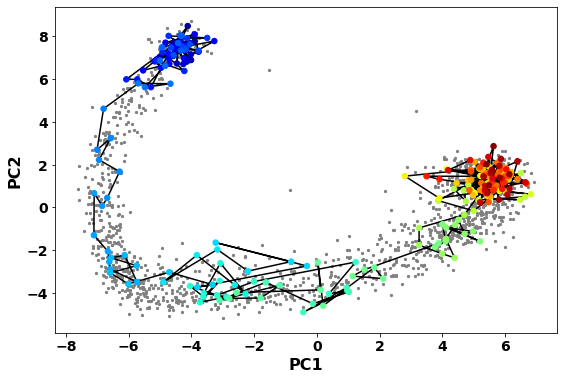

In [12]:
fig,ax=plt.subplots(figsize=(9,6))

# plt.scatter(adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,c=np.unique(adata.obs['sample'], return_inverse=True)[1],cmap='jet')
plt.scatter(-adata.obsm['X_pca'][:,0],adata.obsm['X_pca'][:,1],s=5,color='grey')

color_arr=['black']
for i in range(1):#(len(traj_arrs)):
    
    plt.plot(-traj_arrs[i][:,0],traj_arrs[i][:,1],color=color_arr[i])
    dot_color=np.arange(traj_arrs[i].shape[0])
    
    plt.scatter(-traj_arrs[i][:,0],traj_arrs[i][:,1],s=30,c=dot_color,cmap=plt.cm.jet,zorder=10)
plt.xlabel('PC1',fontsize=16,fontweight='bold')
plt.ylabel('PC2',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'EG_traj.png',dpi=300)
plt.show()

In [10]:
if not os.path.exists('result/EG_dyn_traj'):
    os.makedirs('result/EG_dyn_traj')
for i in range(len(traj_arrs)):
#       np.save('result/emt_dyn_traj/'+str(i)+'.npy',traj_arrs[i])
    adata_arrs[i].write(filename='result/EG_dyn_traj/'+str(i)+'.h5ad')